In [4]:
# Import necessary libraries

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2
from PIL import Image
from skimage.feature import graycomatrix, graycoprops

# System and File Handling
import os
import glob

# Set visualization style for better plots
plt.style.use('ggplot')

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All libraries imported successfully!")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")

All libraries imported successfully!
OpenCV Version: 4.12.0
Pandas Version: 2.3.3
NumPy Version: 2.2.6


In [7]:
# Step 2: Load and Map HAM10000 Dataset

# Define paths
metadata_path = 'HAM10000_metadata.csv'
images_dir_1 = 'HAM10000_images_part_1'
images_dir_2 = 'HAM10000_images_part_2'

# Load metadata CSV
print("Loading metadata...")
df = pd.read_csv(metadata_path)
print(f"Total rows in CSV: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

# Scan both image directories and create a mapping dictionary
print("\nScanning image directories...")
image_path_mapping = {}

# Scan part 1
for img_file in glob.glob(os.path.join(images_dir_1, '*.jpg')):
    # Extract filename without extension (e.g., 'ISIC_0027419' from 'ISIC_0027419.jpg')
    image_id = os.path.splitext(os.path.basename(img_file))[0]
    # Store the absolute path
    image_path_mapping[image_id] = os.path.abspath(img_file)

# Scan part 2
for img_file in glob.glob(os.path.join(images_dir_2, '*.jpg')):
    image_id = os.path.splitext(os.path.basename(img_file))[0]
    image_path_mapping[image_id] = os.path.abspath(img_file)

print(f"Total images found on disk: {len(image_path_mapping)}")

# Map image_id from DataFrame to the image paths
df['image_path'] = df['image_id'].map(image_path_mapping)

# Check for missing images (NaN in image_path column)
missing_images = df['image_path'].isna().sum()
print(f"\nImages not found on disk: {missing_images}")

if missing_images > 0:
    print(f"Dropping {missing_images} rows with missing images...")
    df = df.dropna(subset=['image_path'])
    df = df.reset_index(drop=True)

# Validation summary
print(f"\n{'='*60}")
print(f"Dataset Summary:")
print(f"{'='*60}")
print(f"Total rows in CSV:        {len(pd.read_csv(metadata_path))}")
print(f"Total images found:       {len(image_path_mapping)}")
print(f"Final dataset size:       {len(df)}")
print(f"{'='*60}")

# Display first 5 rows to verify paths
print("\nFirst 5 rows with image paths:")
print(df.head())

Loading metadata...
Total rows in CSV: 10015
Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

Scanning image directories...
Total images found on disk: 10015

Images not found on disk: 0

Dataset Summary:
Total rows in CSV:        10015
Total images found:       10015
Final dataset size:       10015

First 5 rows with image paths:
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  
0  c:\Users\ibrah\Desktop\New Project\HAM10000_im...  
1  c:\Users\ibrah\Desktop\New Project\HAM10000_im...  
2  c:\Users\ibrah\Desktop\New Project\HAM10000_

In [8]:
# Step 3: Data Cleaning and Anomaly Detection

print("="*70)
print("STEP 3: DATA CLEANING AND ANOMALY DETECTION")
print("="*70)

# 1. Check for missing values (nulls) in the DataFrame
print("\n1. Missing Values Check:")
print("-" * 70)
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")

if missing_values.sum() > 0:
    print("\nColumns with missing values:")
    for col in missing_values[missing_values > 0].index:
        print(f"  - {col}: {missing_values[col]} missing ({(missing_values[col]/len(df)*100):.2f}%)")

# 2. Check for duplicate entries
print("\n" + "="*70)
print("2. Duplicate Entries Check:")
print("-" * 70)
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")

# Check for duplicate image_ids
duplicate_image_ids = df['image_id'].duplicated().sum()
print(f"Duplicate image_ids: {duplicate_image_ids}")

# Check for duplicate lesion_ids (same lesion can have multiple images)
duplicate_lesion_ids = df['lesion_id'].duplicated().sum()
print(f"Duplicate lesion_ids: {duplicate_lesion_ids} (Note: Same lesion can have multiple images)")

# 3. Image Integrity Check - Load first 50 images
print("\n" + "="*70)
print("3. Image Integrity Check (First 50 Images):")
print("-" * 70)

corrupted_images = []
valid_images = 0

for idx in range(min(50, len(df))):
    img_path = df.loc[idx, 'image_path']
    image_id = df.loc[idx, 'image_id']
    
    # Attempt to load the image using OpenCV
    img = cv2.imread(img_path)
    
    if img is None:
        warning_msg = f"⚠️  WARNING: Failed to load image {idx+1}/50 - {image_id} at path: {img_path}"
        print(warning_msg)
        corrupted_images.append(image_id)
    else:
        valid_images += 1

print(f"\n✓ Successfully loaded: {valid_images}/{min(50, len(df))} images")
print(f"✗ Failed to load: {len(corrupted_images)}/{min(50, len(df))} images")

if corrupted_images:
    print(f"\nCorrupted image IDs: {corrupted_images}")

# 4. Print total number of valid samples
print("\n" + "="*70)
print("4. Final Dataset Summary:")
print("-" * 70)
print(f"Total samples in dataset: {len(df)}")
print(f"Valid samples (based on integrity check): {len(df) - len(corrupted_images)}")
print(f"Samples ready for training: {len(df)}")
print("="*70)

# Additional info
print(f"\nDataset shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

STEP 3: DATA CLEANING AND ANOMALY DETECTION

1. Missing Values Check:
----------------------------------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
image_path       0
dtype: int64

Total missing values: 57

Columns with missing values:
  - age: 57 missing (0.57%)

2. Duplicate Entries Check:
----------------------------------------------------------------------
Total duplicate rows: 0
Duplicate image_ids: 0
Duplicate lesion_ids: 2545 (Note: Same lesion can have multiple images)

3. Image Integrity Check (First 50 Images):
----------------------------------------------------------------------

✓ Successfully loaded: 50/50 images
✗ Failed to load: 0/50 images

4. Final Dataset Summary:
----------------------------------------------------------------------
Total samples in dataset: 10015
Valid samples (based on integrity check): 10015
Samples ready for training: 10

STEP 4: EXPLORATORY DATA ANALYSIS

1. Label Dictionary:
----------------------------------------------------------------------
Diagnostic Categories:
  nv     -> Melanocytic nevi
  mel    -> Melanoma
  bkl    -> Benign keratosis-like lesions
  bcc    -> Basal cell carcinoma
  akiec  -> Actinic keratoses
  vasc   -> Vascular lesions
  df     -> Dermatofibroma

2. Class Distribution:
----------------------------------------------------------------------

Exact Counts per Class:
  akiec  (Actinic keratoses                  ):   327 samples ( 3.27%)
  bcc    (Basal cell carcinoma               ):   514 samples ( 5.13%)
  bkl    (Benign keratosis-like lesions      ):  1099 samples (10.97%)
  df     (Dermatofibroma                     ):   115 samples ( 1.15%)
  mel    (Melanoma                           ):  1113 samples (11.11%)
  nv     (Melanocytic nevi                   ):  6705 samples (66.95%)
  vasc   (Vascular lesions                   ):   142 samples ( 1.42%)

Total: 10015 samples


C:\Users\ibrah\AppData\Local\Temp\ipykernel_11564\3737121125.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
C:\Users\ibrah\AppData\Local\Temp\ipykernel_11564\3737121125.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{code}\n({label_dict[code]})" for code in class_counts.index],


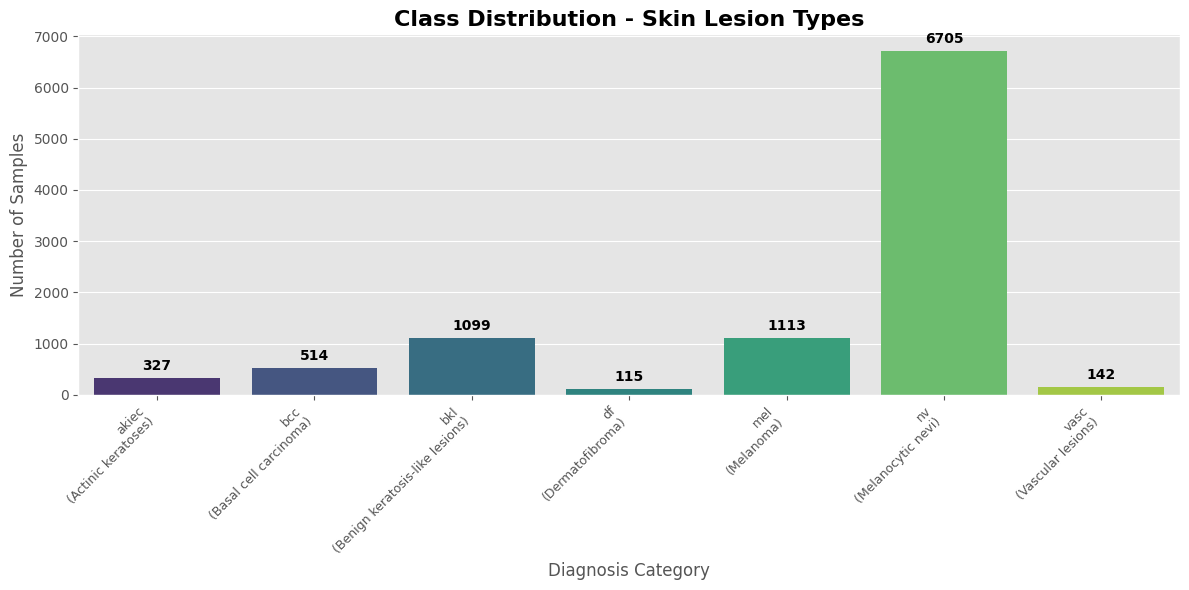


⚠️  Dataset is IMBALANCED - consider stratified sampling during train/test split!


In [9]:
# Step 4: Exploratory Data Analysis (EDA)

print("="*70)
print("STEP 4: EXPLORATORY DATA ANALYSIS")
print("="*70)

# 1. Create Label Dictionary - Map short codes to full names
print("\n1. Label Dictionary:")
print("-" * 70)

label_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

print("Diagnostic Categories:")
for code, name in label_dict.items():
    print(f"  {code:6s} -> {name}")

# 2. Class Distribution - Bar Plot
print("\n" + "="*70)
print("2. Class Distribution:")
print("-" * 70)

# Get exact counts
class_counts = df['dx'].value_counts().sort_index()
print("\nExact Counts per Class:")
for dx_code, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {dx_code:6s} ({label_dict[dx_code]:35s}): {count:5d} samples ({percentage:5.2f}%)")

print(f"\nTotal: {len(df)} samples")
print(f"Number of classes: {df['dx'].nunique()}")

# Create bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution - Skin Lesion Types', fontsize=16, fontweight='bold')
plt.xlabel('Diagnosis Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Add value labels on top of bars
for i, (idx, val) in enumerate(class_counts.items()):
    ax.text(i, val + 100, str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add full names as x-tick labels
ax.set_xticklabels([f"{code}\n({label_dict[code]})" for code in class_counts.index], 
                    rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

print("\n⚠️  Dataset is IMBALANCED - consider stratified sampling during train/test split!")

3. Sample Visualization - 4 Examples per Class:
----------------------------------------------------------------------
Visualizing 7 classes with 4 examples each



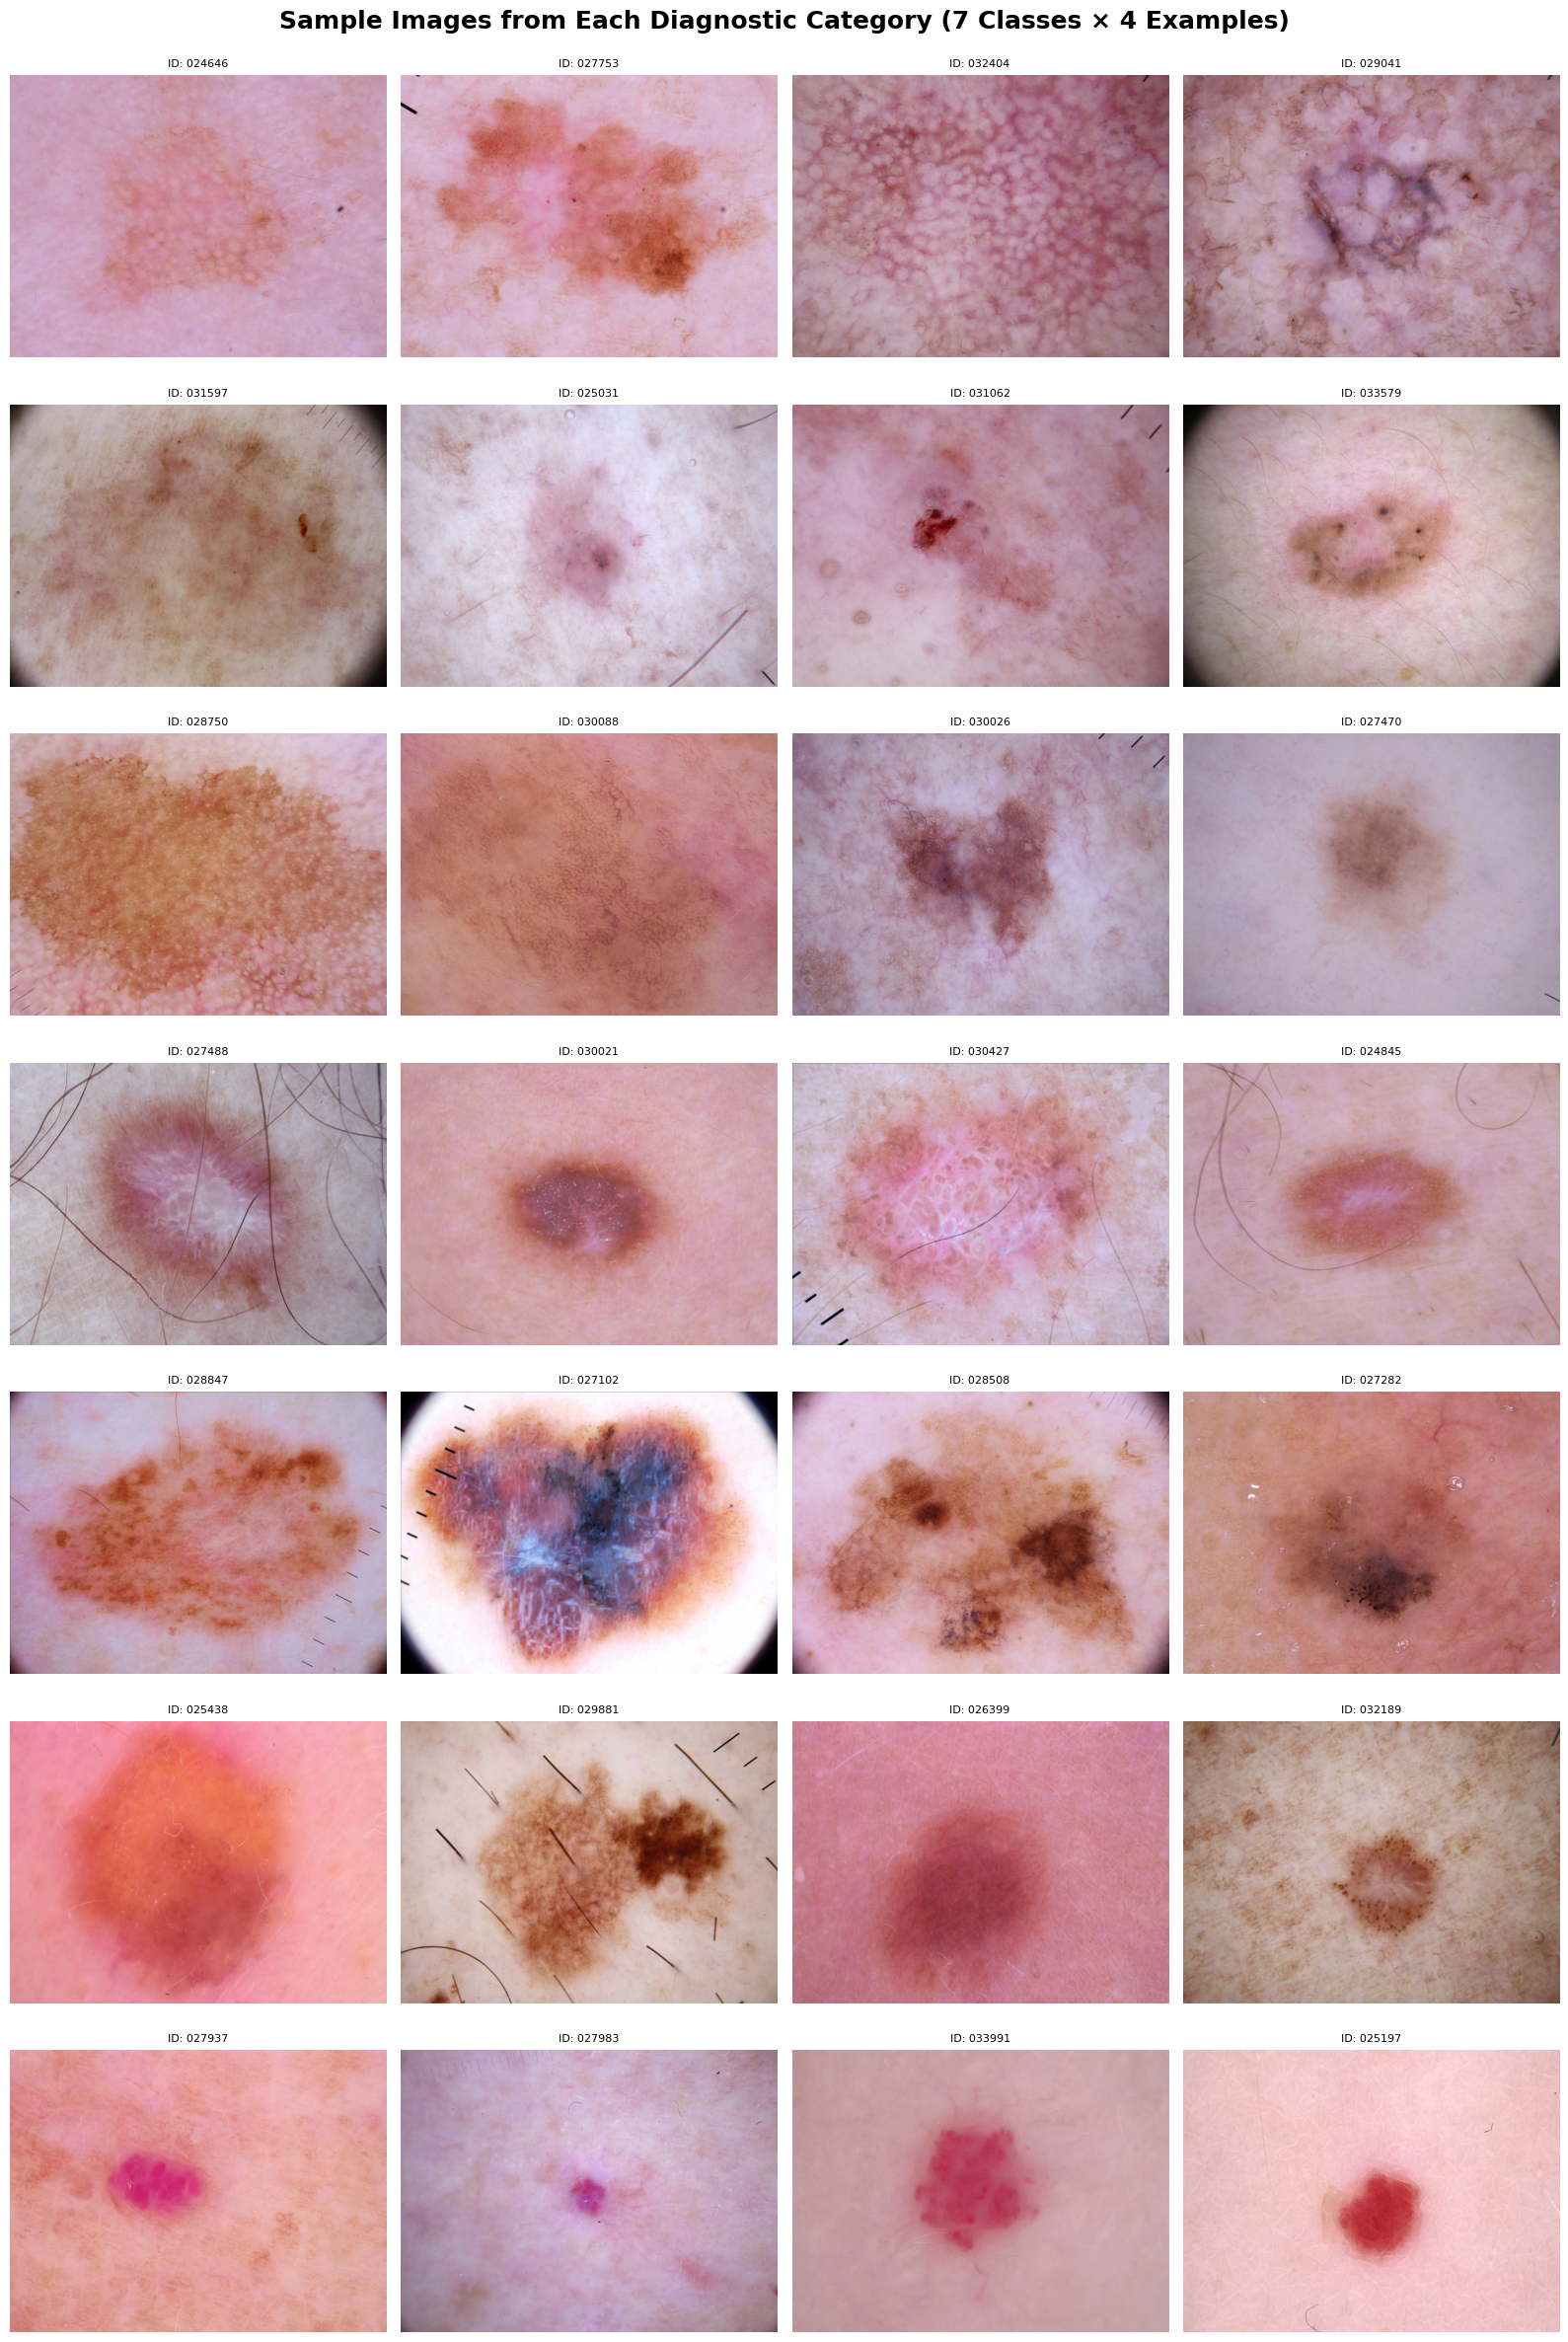

✓ Visualization complete!


In [10]:
# Step 4 (continued): Sample Visualization - Grid Plot (7x4)

print("="*70)
print("3. Sample Visualization - 4 Examples per Class:")
print("-" * 70)

# Get unique classes
unique_classes = sorted(df['dx'].unique())
print(f"Visualizing {len(unique_classes)} classes with 4 examples each\n")

# Create a 7x4 grid (7 classes, 4 examples each)
fig, axes = plt.subplots(7, 4, figsize=(16, 24))
fig.suptitle('Sample Images from Each Diagnostic Category (7 Classes × 4 Examples)', 
             fontsize=18, fontweight='bold', y=0.995)

for i, dx_class in enumerate(unique_classes):
    # Get samples for this class
    class_samples = df[df['dx'] == dx_class].sample(n=min(4, len(df[df['dx'] == dx_class])), 
                                                      random_state=42)
    
    for j, (idx, row) in enumerate(class_samples.iterrows()):
        ax = axes[i, j]
        
        # Load and display image
        img_path = row['image_path']
        img = cv2.imread(img_path)
        
        if img is not None:
            # Convert BGR to RGB for proper display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_rgb)
        else:
            ax.text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', 
                   fontsize=12, color='red')
        
        # Set title with class info (only on first column)
        if j == 0:
            title = f"{dx_class.upper()}: {label_dict[dx_class]}"
            ax.set_ylabel(title, fontsize=11, fontweight='bold', rotation=0, 
                         ha='right', va='center', labelpad=40)
        
        ax.set_title(f"ID: {row['image_id'][-6:]}", fontsize=8)
        ax.axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

In [11]:
# Step 5: Feature Extraction Function Definition
# ================================================
# Based on the ABCD rule (focusing on Color and Texture)
# - Color Features: HSV Histograms (robust to lighting changes)
# - Texture Features: GLCM (captures surface roughness/smoothness)

print("="*70)
print("STEP 5: FEATURE EXTRACTION PIPELINE")
print("="*70)

def extract_features(image_path, img_size=(128, 128)):
    """
    Extract Color (HSV) and Texture (GLCM) features from a skin lesion image.
    
    Parameters:
    -----------
    image_path : str
        Full path to the image file
    img_size : tuple
        Target size for resizing (default: 128x128)
    
    Returns:
    --------
    features : numpy array
        Feature vector containing:
        - 16 bins for Hue histogram
        - 8 bins for Saturation histogram  
        - 8 bins for Value histogram
        - 4 GLCM texture properties (contrast, energy, homogeneity, correlation)
        Total: 36 features
    """
    
    # 1. Read and resize image
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, img_size)
    
    # =========================================================================
    # FEATURE SET 1: COLOR FEATURES (HSV Histograms)
    # =========================================================================
    # Why HSV? RGB mixes color and lighting. HSV separates:
    # - Hue: The actual color (redness, brownness)
    # - Saturation: Color intensity
    # - Value: Brightness
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Calculate histograms for each channel
    # Hue: 16 bins (0-180 range in OpenCV), fewer bins = more robust
    # Saturation & Value: 8 bins each (0-256 range)
    hist_h = cv2.calcHist([hsv_img], [0], None, [16], [0, 180]).flatten()
    hist_s = cv2.calcHist([hsv_img], [1], None, [8], [0, 256]).flatten()
    hist_v = cv2.calcHist([hsv_img], [2], None, [8], [0, 256]).flatten()
    
    # Normalize histograms (makes features scale-invariant)
    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    cv2.normalize(hist_v, hist_v)
    
    # =========================================================================
    # FEATURE SET 2: TEXTURE FEATURES (GLCM - Gray Level Co-occurrence Matrix)
    # =========================================================================
    # Why GLCM? Melanoma often has rough/chaotic texture vs smooth benign moles
    # GLCM counts how often pixel pairs with specific values appear at specific distances
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate GLCM at distance=1 and 4 angles (0°, 45°, 90°, 135°)
    # This captures texture patterns in all directions
    glcm = graycomatrix(gray, 
                        distances=[1], 
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256,
                        symmetric=True, 
                        normed=True)
    
    # Extract texture statistics (averaged across all angles for rotation invariance)
    contrast = np.mean(graycoprops(glcm, 'contrast'))       # Intensity contrast between pixels
    energy = np.mean(graycoprops(glcm, 'energy'))           # Uniformity/orderliness
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity')) # Closeness to diagonal
    correlation = np.mean(graycoprops(glcm, 'correlation')) # Linear dependency of gray levels
    
    # =========================================================================
    # COMBINE ALL FEATURES INTO A SINGLE VECTOR
    # =========================================================================
    features = np.concatenate([
        hist_h,      # 16 features (Hue histogram)
        hist_s,      # 8 features (Saturation histogram)
        hist_v,      # 8 features (Value histogram)
        [contrast, energy, homogeneity, correlation]  # 4 GLCM features
    ])
    
    return features

# Test the function on a single image
print("\nTesting feature extraction on a single image...")
test_img_path = df.loc[0, 'image_path']
test_features = extract_features(test_img_path)

print(f"\n✓ Feature extraction successful!")
print(f"  - Image path: {test_img_path}")
print(f"  - Feature vector length: {len(test_features)}")
print(f"  - Feature breakdown:")
print(f"      • Hue histogram (H):     16 bins")
print(f"      • Saturation histogram (S): 8 bins")
print(f"      • Value histogram (V):    8 bins")
print(f"      • GLCM texture features:  4 values")
print(f"      • TOTAL:                 {len(test_features)} features per image")
print(f"\n  - Sample feature values (first 10): {test_features[:10].round(4)}")

STEP 5: FEATURE EXTRACTION PIPELINE

Testing feature extraction on a single image...

✓ Feature extraction successful!
  - Image path: c:\Users\ibrah\Desktop\New Project\HAM10000_images_part_1\ISIC_0027419.jpg
  - Feature vector length: 36
  - Feature breakdown:
      • Hue histogram (H):     16 bins
      • Saturation histogram (S): 8 bins
      • Value histogram (V):    8 bins
      • GLCM texture features:  4 values
      • TOTAL:                 36 features per image

  - Sample feature values (first 10): [1.615e-01 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]


In [12]:
# Step 5 (continued): Extract Features from ALL Images
# =====================================================
# This will take several minutes due to 10,000+ images

from tqdm import tqdm  # Progress bar

print("="*70)
print("EXTRACTING FEATURES FROM ALL IMAGES")
print("="*70)
print(f"\nTotal images to process: {len(df)}")
print("This may take 5-15 minutes depending on your hardware...\n")

# Initialize lists to store features and labels
X = []  # Feature vectors
y = []  # Labels (diagnosis codes)
failed_images = []  # Track any failed extractions

# Extract features from each image with progress bar
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    img_path = row['image_path']
    label = row['dx']
    
    # Extract features
    features = extract_features(img_path)
    
    if features is not None:
        X.append(features)
        y.append(label)
    else:
        failed_images.append(row['image_id'])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("\n" + "="*70)
print("FEATURE EXTRACTION COMPLETE!")
print("="*70)
print(f"\n✓ Successfully extracted features from: {len(X)} images")
print(f"✗ Failed extractions: {len(failed_images)}")

if failed_images:
    print(f"  Failed image IDs: {failed_images[:10]}{'...' if len(failed_images) > 10 else ''}")

print(f"\nFeature Matrix (X) shape: {X.shape}")
print(f"  - {X.shape[0]} samples (images)")
print(f"  - {X.shape[1]} features per sample")
print(f"\nLabel Vector (y) shape: {y.shape}")
print(f"  - Unique classes: {np.unique(y)}")

# Memory usage estimation
memory_mb = X.nbytes / (1024 * 1024)
print(f"\nFeature matrix memory usage: {memory_mb:.2f} MB")

EXTRACTING FEATURES FROM ALL IMAGES

Total images to process: 10015
This may take 5-15 minutes depending on your hardware...



Extracting features: 100%|██████████| 10015/10015 [15:33<00:00, 10.73it/s] 



FEATURE EXTRACTION COMPLETE!

✓ Successfully extracted features from: 10015 images
✗ Failed extractions: 0

Feature Matrix (X) shape: (10015, 36)
  - 10015 samples (images)
  - 36 features per sample

Label Vector (y) shape: (10015,)
  - Unique classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']

Feature matrix memory usage: 2.75 MB


In [13]:
# Step 6: Preprocessing (Encoding, Splitting, & Scaling)
# ======================================================

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

print("="*70)
print("STEP 6: DATA PREPROCESSING")
print("="*70)

# =========================================================================
# 1. LABEL ENCODING
# =========================================================================
# Convert string labels ('nv', 'mel', etc.) to integers (0, 1, 2, ...)

print("\n1. Label Encoding:")
print("-" * 70)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label Mapping (Integer -> Class Name):")
for i, class_name in enumerate(label_encoder.classes_):
    full_name = label_dict.get(class_name, class_name)
    print(f"  {i} -> {class_name:6s} ({full_name})")

print(f"\nOriginal labels (first 10): {y[:10]}")
print(f"Encoded labels (first 10):  {y_encoded[:10]}")

# =========================================================================
# 2. STRATIFIED TRAIN-TEST SPLIT
# =========================================================================
# 80% Training, 20% Testing
# stratify=y_encoded ensures rare classes are proportionally represented

print("\n" + "="*70)
print("2. Stratified Train-Test Split (80/20):")
print("-" * 70)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=0.20,
    random_state=42,
    stratify=y_encoded  # CRITICAL for imbalanced data!
)

print(f"✓ Split completed with stratification")
print(f"\nTraining set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# =========================================================================
# 3. FEATURE SCALING (Standardization)
# =========================================================================
# StandardScaler: mean=0, std=1 (required for SVM!)
# IMPORTANT: Fit on training data ONLY, then transform both

print("\n" + "="*70)
print("3. Feature Scaling (Standardization):")
print("-" * 70)

scaler = StandardScaler()

# Fit on training data only (prevents data leakage)
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print("✓ StandardScaler fitted on training data")
print("✓ Both training and testing data transformed")
print(f"\nBefore scaling - X_train mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"After scaling  - X_train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")

# =========================================================================
# 4. VERIFICATION
# =========================================================================
print("\n" + "="*70)
print("4. Verification:")
print("-" * 70)

print("\nDataset Shapes:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_test_scaled:  {X_test_scaled.shape}")
print(f"  y_train:        {y_train.shape}")
print(f"  y_test:         {y_test.shape}")

# Verify stratification worked - check class distribution in test set
print("\nClass Distribution in Test Set (Confirming Stratification):")
unique, counts = np.unique(y_test, return_counts=True)
print(f"{'Class':<8} {'Name':<35} {'Count':>6} {'%':>8}")
print("-" * 60)
for cls, cnt in zip(unique, counts):
    class_name = label_encoder.classes_[cls]
    full_name = label_dict.get(class_name, class_name)
    pct = cnt / len(y_test) * 100
    print(f"{cls:<8} {full_name:<35} {cnt:>6} {pct:>7.2f}%")

print("\n" + "="*70)
print("✓ PREPROCESSING COMPLETE - Data ready for model training!")
print("="*70)

STEP 6: DATA PREPROCESSING

1. Label Encoding:
----------------------------------------------------------------------
Label Mapping (Integer -> Class Name):
  0 -> akiec  (Actinic keratoses)
  1 -> bcc    (Basal cell carcinoma)
  2 -> bkl    (Benign keratosis-like lesions)
  3 -> df     (Dermatofibroma)
  4 -> mel    (Melanoma)
  5 -> nv     (Melanocytic nevi)
  6 -> vasc   (Vascular lesions)

Original labels (first 10): ['bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl' 'bkl']
Encoded labels (first 10):  [2 2 2 2 2 2 2 2 2 2]

2. Stratified Train-Test Split (80/20):
----------------------------------------------------------------------
✓ Split completed with stratification

Training set: 8012 samples (80.0%)
Testing set:  2003 samples (20.0%)

3. Feature Scaling (Standardization):
----------------------------------------------------------------------
✓ StandardScaler fitted on training data
✓ Both training and testing data transformed

Before scaling - X_train mean: 1.9694, std: 1

STEP 7: SUPPORT VECTOR MACHINE (SVM) TRAINING

SVM Configuration:
----------------------------------------------------------------------
  • Kernel:       RBF (Radial Basis Function)
  • Class Weight: balanced (handles imbalanced data)
  • C (regularization): 2.0
  • Gamma: scale (auto-calculated)

Training SVM Classifier...
----------------------------------------------------------------------
Training samples: 8012
Features per sample: 36

✓ Training completed in 5.30 seconds

Making Predictions...
----------------------------------------------------------------------
Training Accuracy: 64.55%
Testing Accuracy:  59.56%

✓ No significant overfitting detected

Classification Report (Test Set):
              precision    recall  f1-score   support

       akiec      0.232     0.600     0.335        65
         bcc      0.305     0.447     0.362       103
         bkl      0.384     0.405     0.394       220
          df      0.127     0.435     0.196        23
         mel      0.367   

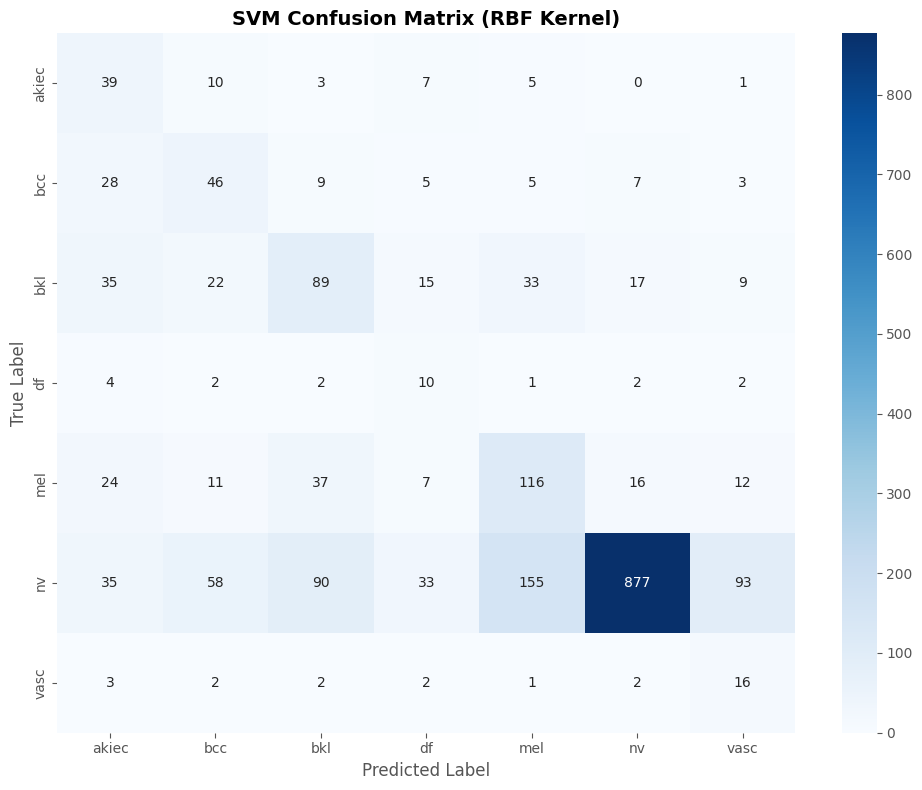


SVM MODEL SUMMARY
  • Kernel: RBF
  • Training Time: 5.30 seconds
  • Training Accuracy: 64.55%
  • Testing Accuracy: 59.56%
  • Number of Support Vectors: 5914


In [17]:
# Step 7: Train Support Vector Machine (SVM) Classifier
# ======================================================
# SVM with RBF kernel - finds optimal non-linear decision boundaries

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

print("="*70)
print("STEP 7: SUPPORT VECTOR MACHINE (SVM) TRAINING")
print("="*70)

# =========================================================================
# SVM CONFIGURATION
# =========================================================================
# kernel='rbf': Radial Basis Function (for non-linear patterns)
# class_weight='balanced': Automatically adjusts weights for imbalanced classes
# C=1.0: Regularization parameter (default, can tune later)
# gamma='scale': Kernel coefficient (1 / (n_features * X.var()))
# random_state=42: For reproducibility

print("\nSVM Configuration:")
print("-" * 70)
print("  • Kernel:       RBF (Radial Basis Function)")
print("  • Class Weight: balanced (handles imbalanced data)")
print("  • C (regularization): 2.0")
print("  • Gamma: scale (auto-calculated)")

# Initialize SVM classifier
svm_classifier = SVC(
    kernel='rbf',           # Non-linear kernel - CRITICAL for this task
    class_weight='balanced', # Handle class imbalance
    C=2.0,                  # Regularization strength
    gamma='scale',          # Kernel coefficient
    random_state=42,
    verbose=False
)

# =========================================================================
# TRAINING
# =========================================================================
print("\n" + "="*70)
print("Training SVM Classifier...")
print("-" * 70)
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Features per sample: {X_train_scaled.shape[1]}")

start_time = time.time()
svm_classifier.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

print(f"\n✓ Training completed in {training_time:.2f} seconds")

# =========================================================================
# PREDICTIONS
# =========================================================================
print("\n" + "="*70)
print("Making Predictions...")
print("-" * 70)

# Predict on training set (to check for overfitting)
y_train_pred = svm_classifier.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on test set
y_test_pred = svm_classifier.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy:  {test_accuracy*100:.2f}%")

# Check for overfitting
if train_accuracy - test_accuracy > 0.10:
    print("\n⚠️  Warning: Possible overfitting detected (train >> test)")
else:
    print("\n✓ No significant overfitting detected")

# =========================================================================
# DETAILED CLASSIFICATION REPORT
# =========================================================================
print("\n" + "="*70)
print("Classification Report (Test Set):")
print("="*70)

# Get class names for better readability
class_names = [f"{label_encoder.classes_[i]} ({label_dict[label_encoder.classes_[i]]})" 
               for i in range(len(label_encoder.classes_))]

print(classification_report(y_test, y_test_pred, 
                            target_names=label_encoder.classes_,
                            digits=3))

# =========================================================================
# CONFUSION MATRIX
# =========================================================================
print("\n" + "="*70)
print("Confusion Matrix:")
print("="*70)

cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix (RBF Kernel)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# =========================================================================
# SUMMARY
# =========================================================================
print("\n" + "="*70)
print("SVM MODEL SUMMARY")
print("="*70)
print(f"  • Kernel: RBF")
print(f"  • Training Time: {training_time:.2f} seconds")
print(f"  • Training Accuracy: {train_accuracy*100:.2f}%")
print(f"  • Testing Accuracy: {test_accuracy*100:.2f}%")
print(f"  • Number of Support Vectors: {svm_classifier.n_support_.sum()}")
print("="*70)

STEP 8: RANDOM FOREST CLASSIFIER TRAINING

Random Forest Configuration:
----------------------------------------------------------------------
  • n_estimators:  200 (number of trees)
  • max_depth:     None (nodes expand until all leaves are pure)
  • class_weight:  balanced (handles imbalanced data)
  • n_jobs:        -1 (use all CPU cores)

Training Random Forest Classifier...
----------------------------------------------------------------------
Training samples: 8012
Features per sample: 36
Note: Using UNSCALED data (RF is scale-invariant)

✓ Training completed in 7.60 seconds

Making Predictions...
----------------------------------------------------------------------
Training Accuracy: 99.15%
Testing Accuracy:  73.99%

⚠️  Warning: Possible overfitting detected (train >> test)

Classification Report (Test Set):
              precision    recall  f1-score   support

       akiec      0.449     0.338     0.386        65
         bcc      0.465     0.447     0.455       103
       

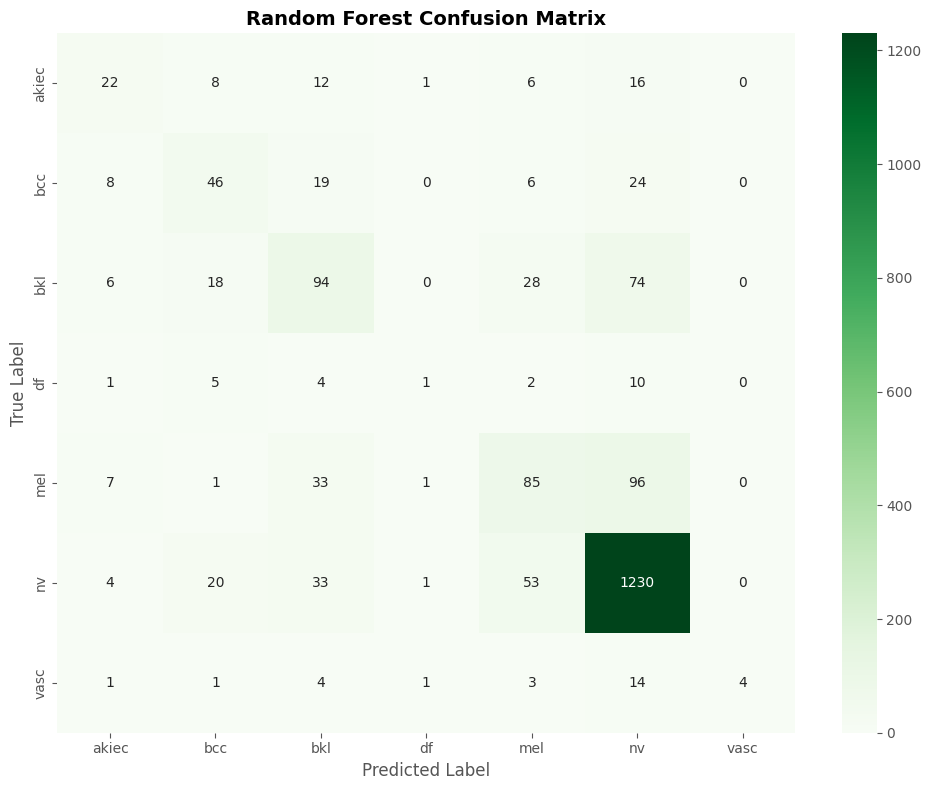


Top 10 Most Important Features:
Rank   Feature                Importance
----------------------------------------
1      S_5                        0.0608
2      S_1                        0.0559
3      GLCM_Correlation           0.0553
4      S_4                        0.0541
5      V_4                        0.0500
6      GLCM_Energy                0.0445
7      H_14                       0.0434
8      V_3                        0.0431
9      GLCM_Homogeneity           0.0422
10     S_3                        0.0420

RANDOM FOREST MODEL SUMMARY
  • Number of Trees: 200
  • Training Time: 7.60 seconds
  • Training Accuracy: 99.15%
  • Testing Accuracy: 73.99%


In [18]:
# Step 8: Train Random Forest Classifier
# =======================================
# Random Forest - ensemble of decision trees

from sklearn.ensemble import RandomForestClassifier

print("="*70)
print("STEP 8: RANDOM FOREST CLASSIFIER TRAINING")
print("="*70)

# =========================================================================
# RANDOM FOREST CONFIGURATION
# =========================================================================
print("\nRandom Forest Configuration:")
print("-" * 70)
print("  • n_estimators:  200 (number of trees)")
print("  • max_depth:     None (nodes expand until all leaves are pure)")
print("  • class_weight:  balanced (handles imbalanced data)")
print("  • n_jobs:        -1 (use all CPU cores)")

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=200,        # Number of trees in the forest
    max_depth=None,          # Let trees grow fully
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples at leaf node
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    n_jobs=-1,               # Use all CPU cores for parallel training
    verbose=0
)

# =========================================================================
# TRAINING (using UNSCALED data - RF doesn't need scaling!)
# =========================================================================
print("\n" + "="*70)
print("Training Random Forest Classifier...")
print("-" * 70)
print(f"Training samples: {X_train.shape[0]}")
print(f"Features per sample: {X_train.shape[1]}")
print("Note: Using UNSCALED data (RF is scale-invariant)")

start_time_rf = time.time()
rf_classifier.fit(X_train, y_train)  # Using unscaled X_train
training_time_rf = time.time() - start_time_rf

print(f"\n✓ Training completed in {training_time_rf:.2f} seconds")

# =========================================================================
# PREDICTIONS
# =========================================================================
print("\n" + "="*70)
print("Making Predictions...")
print("-" * 70)

# Predict on training set
y_train_pred_rf = rf_classifier.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)

# Predict on test set
y_test_pred_rf = rf_classifier.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Training Accuracy: {train_accuracy_rf*100:.2f}%")
print(f"Testing Accuracy:  {test_accuracy_rf*100:.2f}%")

# Check for overfitting
if train_accuracy_rf - test_accuracy_rf > 0.15:
    print("\n⚠️  Warning: Possible overfitting detected (train >> test)")
else:
    print("\n✓ Model generalization looks reasonable")

# =========================================================================
# DETAILED CLASSIFICATION REPORT
# =========================================================================
print("\n" + "="*70)
print("Classification Report (Test Set):")
print("="*70)

print(classification_report(y_test, y_test_pred_rf, 
                            target_names=label_encoder.classes_,
                            digits=3))

# =========================================================================
# CONFUSION MATRIX
# =========================================================================
print("\n" + "="*70)
print("Confusion Matrix:")
print("="*70)

cm_rf = confusion_matrix(y_test, y_test_pred_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# =========================================================================
# FEATURE IMPORTANCE
# =========================================================================
print("\n" + "="*70)
print("Top 10 Most Important Features:")
print("="*70)

feature_names = [f"H_{i}" for i in range(16)] + \
                [f"S_{i}" for i in range(8)] + \
                [f"V_{i}" for i in range(8)] + \
                ["GLCM_Contrast", "GLCM_Energy", "GLCM_Homogeneity", "GLCM_Correlation"]

importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1][:10]

print(f"{'Rank':<6} {'Feature':<20} {'Importance':>12}")
print("-" * 40)
for rank, idx in enumerate(indices, 1):
    print(f"{rank:<6} {feature_names[idx]:<20} {importances[idx]:>12.4f}")

# =========================================================================
# SUMMARY
# =========================================================================
print("\n" + "="*70)
print("RANDOM FOREST MODEL SUMMARY")
print("="*70)
print(f"  • Number of Trees: 200")
print(f"  • Training Time: {training_time_rf:.2f} seconds")
print(f"  • Training Accuracy: {train_accuracy_rf*100:.2f}%")
print(f"  • Testing Accuracy: {test_accuracy_rf*100:.2f}%")
print("="*70)

STEP 9: OPTIMIZED RANDOM FOREST (Reduced Overfitting)

Optimized Configuration:
----------------------------------------------------------------------
  • n_estimators:    300 (more trees for stability)
  • max_depth:       20 (limit tree depth to reduce overfitting)
  • min_samples_split: 10
  • min_samples_leaf:  5
  • class_weight:    balanced

Training Optimized Random Forest...
✓ Training completed in 13.08 seconds

Training Accuracy: 90.35%
Testing Accuracy:  69.95%
Overfitting Gap:   20.41%

Classification Report (Optimized RF):
              precision    recall  f1-score   support

       akiec      0.359     0.431     0.392        65
         bcc      0.382     0.583     0.462       103
         bkl      0.424     0.445     0.435       220
          df      0.455     0.217     0.294        23
         mel      0.388     0.520     0.444       223
          nv      0.894     0.810     0.850      1341
        vasc      0.667     0.286     0.400        28

    accuracy            

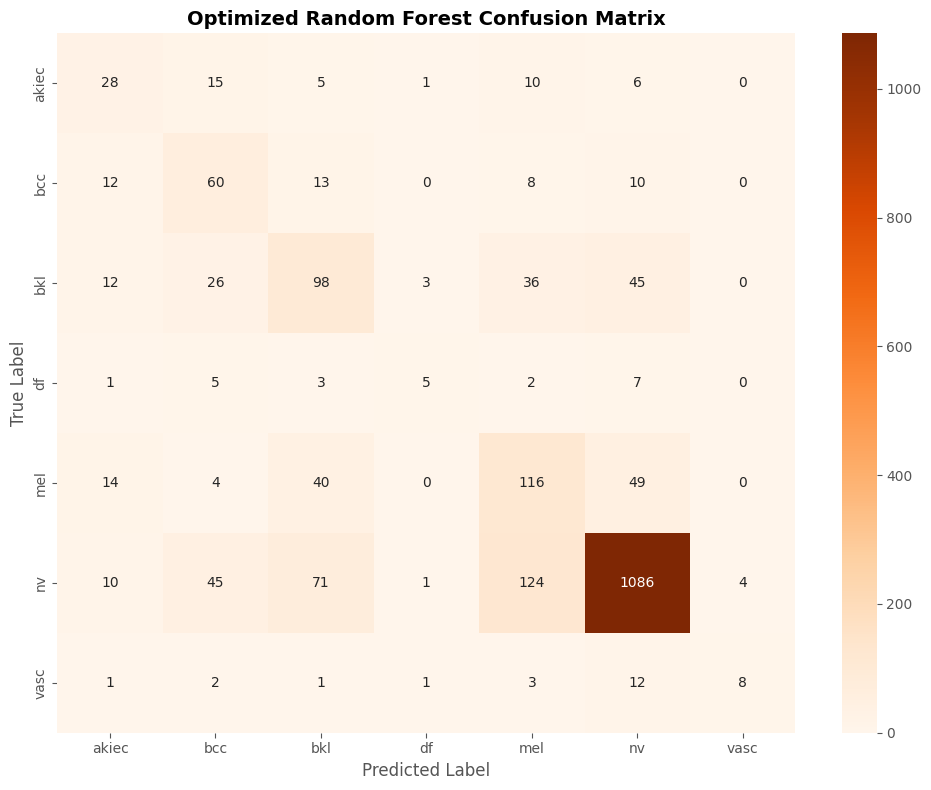

In [19]:
# Step 9: Random Forest with Regularization (Reduce Overfitting)
# ================================================================
# Adding max_depth and increasing min_samples to reduce overfitting

print("="*70)
print("STEP 9: OPTIMIZED RANDOM FOREST (Reduced Overfitting)")
print("="*70)

# =========================================================================
# OPTIMIZED RANDOM FOREST CONFIGURATION
# =========================================================================
print("\nOptimized Configuration:")
print("-" * 70)
print("  • n_estimators:    300 (more trees for stability)")
print("  • max_depth:       20 (limit tree depth to reduce overfitting)")
print("  • min_samples_split: 10")
print("  • min_samples_leaf:  5")
print("  • class_weight:    balanced")

rf_optimized = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,            # LIMIT depth to prevent overfitting
    min_samples_split=10,    # Require more samples to split
    min_samples_leaf=5,      # Require more samples at leaves
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train
print("\nTraining Optimized Random Forest...")
start_time_rf2 = time.time()
rf_optimized.fit(X_train, y_train)
training_time_rf2 = time.time() - start_time_rf2
print(f"✓ Training completed in {training_time_rf2:.2f} seconds")

# Predictions
y_train_pred_rf2 = rf_optimized.predict(X_train)
train_accuracy_rf2 = accuracy_score(y_train, y_train_pred_rf2)

y_test_pred_rf2 = rf_optimized.predict(X_test)
test_accuracy_rf2 = accuracy_score(y_test, y_test_pred_rf2)

print(f"\nTraining Accuracy: {train_accuracy_rf2*100:.2f}%")
print(f"Testing Accuracy:  {test_accuracy_rf2*100:.2f}%")
print(f"Overfitting Gap:   {(train_accuracy_rf2 - test_accuracy_rf2)*100:.2f}%")

# Classification Report
print("\n" + "="*70)
print("Classification Report (Optimized RF):")
print("="*70)
print(classification_report(y_test, y_test_pred_rf2, 
                            target_names=label_encoder.classes_,
                            digits=3))

# Confusion Matrix
cm_rf2 = confusion_matrix(y_test, y_test_pred_rf2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf2, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Optimized Random Forest Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

STEP 10: MODEL COMPARISON

Model Performance Summary:
----------------------------------------------------------------------
                       Model  Train Accuracy  Test Accuracy  Overfitting Gap
1    Random Forest (Default)          0.9915         0.7399           0.2516
2  Random Forest (Optimized)          0.9035         0.6995           0.2041
0                  SVM (RBF)          0.6455         0.5956           0.0499


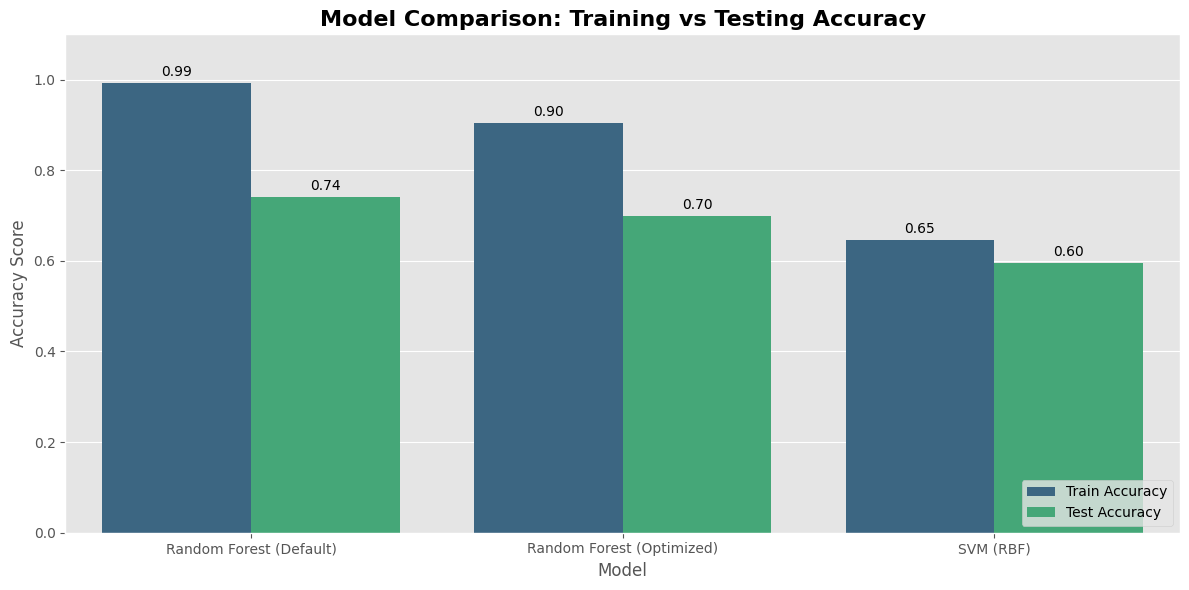


🏆 BEST MODEL: Random Forest (Default)
   Test Accuracy: 73.99%


In [20]:
# Step 10: Model Comparison and Final Selection
# ==============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("STEP 10: MODEL COMPARISON")
print("="*70)

# 1. Compile Results
model_results = [
    {
        'Model': 'SVM (RBF)',
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Overfitting Gap': train_accuracy - test_accuracy
    },
    {
        'Model': 'Random Forest (Default)',
        'Train Accuracy': train_accuracy_rf,
        'Test Accuracy': test_accuracy_rf,
        'Overfitting Gap': train_accuracy_rf - test_accuracy_rf
    },
    {
        'Model': 'Random Forest (Optimized)',
        'Train Accuracy': train_accuracy_rf2,
        'Test Accuracy': test_accuracy_rf2,
        'Overfitting Gap': train_accuracy_rf2 - test_accuracy_rf2
    }
]

results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)

print("\nModel Performance Summary:")
print("-" * 70)
print(results_df.round(4))

# 2. Visualization
plt.figure(figsize=(12, 6))

# Melt DataFrame for plotting
results_melted = results_df.melt(id_vars='Model', 
                                 value_vars=['Train Accuracy', 'Test Accuracy'],
                                 var_name='Metric', value_name='Score')

# Bar Plot
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='viridis')
plt.title('Model Comparison: Training vs Testing Accuracy', fontsize=16, fontweight='bold')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(loc='lower right')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# 3. Select Best Model
best_model_name = results_df.iloc[0]['Model']
best_test_acc = results_df.iloc[0]['Test Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc*100:.2f}%")

# Assign the actual model object based on the name
if best_model_name == 'SVM (RBF)':
    final_model = svm_classifier
    is_scaled = True
elif best_model_name == 'Random Forest (Default)':
    final_model = rf_classifier
    is_scaled = False
else:
    final_model = rf_optimized
    is_scaled = False

In [21]:
# Step 11: Save the Best Model and Preprocessing Objects
# ======================================================

import joblib
import os

print("="*70)
print("STEP 11: SAVING MODEL AND ARTIFACTS")
print("="*70)

# Create 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created 'models' directory.")

# Define filenames
model_filename = 'models/skin_cancer_model.pkl'
scaler_filename = 'models/scaler.pkl'
encoder_filename = 'models/label_encoder.pkl'

# 1. Save the Model
print(f"\nSaving {best_model_name} to {model_filename}...")
joblib.dump(final_model, model_filename)

# 2. Save the Scaler (only if needed, but good to save anyway)
# Even if RF doesn't need it, we might want to switch models later
print(f"Saving StandardScaler to {scaler_filename}...")
joblib.dump(scaler, scaler_filename)

# 3. Save the Label Encoder
print(f"Saving LabelEncoder to {encoder_filename}...")
joblib.dump(label_encoder, encoder_filename)

# 4. Save Feature Extraction Metadata (Optional but helpful)
metadata = {
    'model_type': best_model_name,
    'feature_count': X_train.shape[1],
    'requires_scaling': is_scaled,
    'class_mapping': label_dict,
    'classes': label_encoder.classes_.tolist()
}
joblib.dump(metadata, 'models/model_metadata.pkl')

print("\n" + "="*70)
print("✓ ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*70)
print(f"1. Model:     {model_filename}")
print(f"2. Scaler:    {scaler_filename}")
print(f"3. Encoder:   {encoder_filename}")
print(f"4. Metadata:  models/model_metadata.pkl")
print("\nYou can now use these files for inference in a separate script or app.")

STEP 11: SAVING MODEL AND ARTIFACTS
Created 'models' directory.

Saving Random Forest (Default) to models/skin_cancer_model.pkl...
Saving StandardScaler to models/scaler.pkl...
Saving LabelEncoder to models/label_encoder.pkl...

✓ ALL ARTIFACTS SAVED SUCCESSFULLY!
1. Model:     models/skin_cancer_model.pkl
2. Scaler:    models/scaler.pkl
3. Encoder:   models/label_encoder.pkl
4. Metadata:  models/model_metadata.pkl

You can now use these files for inference in a separate script or app.
